# The YT Frontend for the `QUOKKA` Dataset

## 1. Overview

[Rongjun Huang](https://github.com/Rongjun-ANU) and [Chongchong He](https://github.com/chongchonghe) have written a YT frontend for [`QUOKKA`](https://github.com/quokka-astro/quokka) dataset, enabling seamless integration with `yt`'s data structures and visualization capabilities. We will merge this update into the main `yt` repository soon. Before that, you can install the modified `yt` version available at [https://github.com/chongchonghe/yt](https://github.com/chongchonghe/yt) via

```bash
pip install "yt[quokka] @ git+https://github.com/chongchonghe/yt.git"
```


## 2. Features

### **Header Management**
- **Dynamic Field Detection**:
  - Automatically detects and loads:
    - Six mandatory gas fields (density, energy, internal energy, and x/y/z-momentum)
    - Optional fields, including temperature, scalar, radiation, and magnetic (currently a placeholder) fields 
  - **Units Management**:
    - Maps field names to (field_type, field_name) tuples, e.g., `('boxlib', 'gasDensity')` becomes `('gas', 'density')`.
    - Assigns physical units to dimensionless (or `code_unit`) native fields.

### **Metadata Management**
- Parses `Header` file for fields' information.
- Reads `metadata.yaml` for simulation parameters.
- Handles multi-dimensional data structures.

### **Particle Support**
- Dynamically detects particle types and fields from `*_particles` directories.
- Supports custom particle field units via `Fields.yaml`.

## 3. Changes

1. **`QuokkaDataset`**:
   - Modify `/yt/frontends/amrex/data_structures.py` to extend the `AMReXDataset` class:
     - Verify `QUOKKA` dataset compatibility.
     - Parse files and support additional fluid types.
2. **`QuokkaHierarchy`**:
   - Add `/yt/frontends/amrex/data_structures.py` for managing:
     - Header and metadata reading.
     - Particle information parsing.
3. **`QuokkaFieldInfo`**:
   - Add `/yt/frontends/amrex/fields.py` to manage:
     - Derived, and particle fields.
4. Import the above modules in `/yt/frontends/amrex/api.py`.

## 4. Explanation

### **4.1 Classical `QUOKKA` Dataset**

A standard `QUOKKA` dataset includes the following components:

```bash
dataset_folder/
├── Level_0/         # `QUOKKA` data
├── Header           # Dataset header information
└── metadata.yaml    # Configuration file for YT integration
```

#### **4.1.1 Metadata**
The `metadata.yaml` file is critical for `yt` to recognize a `QUOKKA` dataset. It contains parameters such as:

```yaml
quokka_version: 25.03
units:
  unit_length: .nan
  unit_mass: .nan
  unit_time: .nan
  unit_temperature: .nan
constants:
  k_B: 1
  G: 1
  c: 100
  c_hat: 10
  a_rad: 1
```

#### **4.1.2 Particle Support**
Datasets with particles include additional directories:

```bash
dataset_folder/
├── Level_0/
├── Header
├── metadata.yaml
├── XXX_particles/     # Particle fields (e.g., Rad or Sink or CIC)
│   ├── Fields.yaml    # Particle field names and units
│   ├── Header
│   └── Level_0/
```

The `Fields.yaml` file specifies particle field names and their units, expressed using four fundamental units (`M`, `L`, `T`, and `Θ` for unit mass, unit length, unit time and unit temperature) raised to the power of the corresponding exponents.

An example `Fields.yaml` looks like this:

```yaml
velocity: [0, 1, -1, 0]
luminosity: [1, 2, -3, 0]
```

### **4.2 Loading a `QUOKKA` Dataset**

Here we load the sample data "RadBeam"

In [1]:
# Import yt and load sample data
import yt
ds = yt.load("sample/RadBeam/plt007")
ds

yt : [INFO     ] 2025-03-24 11:19:38,549 Parameters: current_time              = 1.334256380792608e-10
yt : [INFO     ] 2025-03-24 11:19:38,549 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2025-03-24 11:19:38,550 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-24 11:19:38,550 Parameters: domain_right_edge         = [2. 2. 1.]


QuokkaDataset: /Users/cche/softwares/yt/README-of-yt-frontend-for-QUOKKA/sample/RadBeam/plt007

The returned `ds` is a `QuokkaDataset` object, confirming that the dataset is loaded successfully.

### **4.3 Derived Fields**

`QUOKKA` datasets always include six mandatory gas fields. These fields are represented as:
```python
[('boxlib', 'gasDensity'),
 ('boxlib', 'gasEnergy'),
 ('boxlib', 'gasInternalEnergy'),
 ('boxlib', 'x-GasMomentum'),
 ('boxlib', 'y-GasMomentum'),
 ('boxlib', 'z-GasMomentum')]
```
In practice, your dataset may include other native fields in the data object.  
You can use `ds.field_list` to display them:

In [2]:
# Native fields
ds.field_list

[('boxlib', 'gasDensity'),
 ('boxlib', 'gasEnergy'),
 ('boxlib', 'gasInternalEnergy'),
 ('boxlib', 'radEnergy-Group0'),
 ('boxlib', 'x-GasMomentum'),
 ('boxlib', 'x-RadFlux-Group0'),
 ('boxlib', 'y-GasMomentum'),
 ('boxlib', 'y-RadFlux-Group0'),
 ('boxlib', 'z-GasMomentum'),
 ('boxlib', 'z-RadFlux-Group0')]

When your dataset is loaded by `yt`, `yt` will derive some useful fields based on these native `boxlib` field, e.g., `gas`, `rad`, etc.  
You can use `ds.derived_field_list` to display them.


In [3]:
# Derived fields
ds.derived_field_list

[('boxlib', 'cell_volume'),
 ('boxlib', 'dx'),
 ('boxlib', 'dy'),
 ('boxlib', 'dz'),
 ('boxlib', 'gasDensity'),
 ('boxlib', 'gasEnergy'),
 ('boxlib', 'gasInternalEnergy'),
 ('boxlib', 'path_element_x'),
 ('boxlib', 'path_element_y'),
 ('boxlib', 'path_element_z'),
 ('boxlib', 'radEnergy-Group0'),
 ('boxlib', 'volume'),
 ('boxlib', 'x'),
 ('boxlib', 'x-GasMomentum'),
 ('boxlib', 'x-RadFlux-Group0'),
 ('boxlib', 'y'),
 ('boxlib', 'y-GasMomentum'),
 ('boxlib', 'y-RadFlux-Group0'),
 ('boxlib', 'z'),
 ('boxlib', 'z-GasMomentum'),
 ('boxlib', 'z-RadFlux-Group0'),
 ('gas', 'angular_momentum_magnitude'),
 ('gas', 'angular_momentum_x'),
 ('gas', 'angular_momentum_y'),
 ('gas', 'angular_momentum_z'),
 ('gas', 'averaged_density'),
 ('gas', 'cell_mass'),
 ('gas', 'cell_volume'),
 ('gas', 'density'),
 ('gas', 'density_gradient_magnitude'),
 ('gas', 'density_gradient_x'),
 ('gas', 'density_gradient_y'),
 ('gas', 'density_gradient_z'),
 ('gas', 'dx'),
 ('gas', 'dy'),
 ('gas', 'dynamical_time'),
 ('ga

Since all the native `boxlib` fields do not contain physical units in the dataset (`code_unit` by default), we add corresponding units to their derived counterparts. For example, when accessing the gas density field:

In [4]:
ds.r[('boxlib', 'gasDensity')]

unyt_array([1., 1., 1., ..., 1., 1., 1.], 'code_mass/code_length**3')

Derived fields are mapped with physical units by this frontend. 

In [5]:
ds.r[('gas', 'density')]

unyt_array([1., 1., 1., ..., 1., 1., 1.], 'g/cm**3')

### **4.4 Other Header and Metadata Parsing**

You can also check all the infomation from `Header` and `metadata.yaml` relevant to this data object by `ds.parameters`:

In [6]:
ds.parameters

{'plot_file_type': 'HyperCLaw-V1.1',
 'fields': ['gasDensity',
  'x-GasMomentum',
  'y-GasMomentum',
  'z-GasMomentum',
  'gasEnergy',
  'gasInternalEnergy',
  'radEnergy-Group0',
  'x-RadFlux-Group0',
  'y-RadFlux-Group0',
  'z-RadFlux-Group0'],
 'radiation_field_groups': 1,
 'dimensionality': 2,
 'current_time': 1.334256380792608e-10,
 'refinement_level': 2,
 'domain_left_edge': [0.0, 0.0],
 'domain_right_edge': [2.0, 2.0],
 'grid_info': '((0,0) (127,127) (0,0)) ((0,0) (255,255) (0,0)) ((0,0) (511,511) (0,0))',
 'timestamp': [854, 1708, 3416],
 'grid_sizes': [[0.015625, 0.015625],
  [0.0078125, 0.0078125],
  [0.00390625, 0.00390625]],
 'refinement_details': [{'level': 0,
   'num_boxes': 1,
   'current_time': 1.334256380792608e-10,
   'timestamp': 854,
   'boxes': [{'axis_0': {'left_edge': 0.0, 'right_edge': 2.0},
     'axis_1': {'left_edge': 0.0, 'right_edge': 2.0}}]},
  {'level': 1,
   'num_boxes': 12,
   'current_time': 1.334256380792608e-10,
   'timestamp': 1708,
   'boxes': [{'ax

## Face-centered data

Quokka frontend in YT supports face-centered data, which is useful for MHD simulations. The face-centered datasets are stored as sub-datasets in the main dataset. You can access them by `ds.ds_fc_x`, `ds.ds_fc_y`, and `ds.ds_fc_z`.

In [ ]:
import yt 
import numpy as np

def test_fc():
    ds = yt.load("./sample/HydroWave/plt00004")
    print(ds)

    ds_fc_x = ds.ds_fc_x
    assert isinstance(ds_fc_x, yt.frontends.amrex.data_structures.QuokkaDataset)

    print(ds_fc_x)

    print(f"Face-centered x dataset fields: {ds.ds_fc_x.field_list}")

    # get all data and convert to numpy array
    ad = ds_fc_x.all_data()
    field =  ('boxlib', 'x-RiemannSolverVelocity')
    x_flux_array = np.array(ad[field])
    print(type(x_flux_array)) # should be numpy.ndarray
    print(x_flux_array.shape)

test_fc()

### **4.5 Visualizations**

With this `QUOKKA` frontend integration, you can use the full range of visualization capabilities provided by `yt`. Below are examples demonstrating different visualization techniques using our sample dataset:

- Basic slice plots of gas density
- Radiation energy density visualization
- Combined plots with particle annotations

In [1]:
ds = yt.load("sample/RadBeam/plt007")
s1 = yt.SlicePlot(ds, 'z', ('gas', 'density'))
s1.set_zlim(('gas', 'density'), 1e-1, 1e1)
s2 = yt.SlicePlot(ds, 'z', ('rad', 'energy_density_0'))
s1.show()
s2.show()

NameError: name 'yt' is not defined

yt : [INFO     ] 2025-03-24 11:19:40,439 Parameters: current_time              = 0.15000000000000002
yt : [INFO     ] 2025-03-24 11:19:40,439 Parameters: domain_dimensions         = [64 64  1]
yt : [INFO     ] 2025-03-24 11:19:40,439 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-24 11:19:40,440 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-03-24 11:19:40,528 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-03-24 11:19:40,528 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-03-24 11:19:40,529 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-03-24 11:19:40,529 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-03-24 11:19:40,530 Making a fixed resolution buffer of (('rad', 'energy_density_0')) 800 by 800



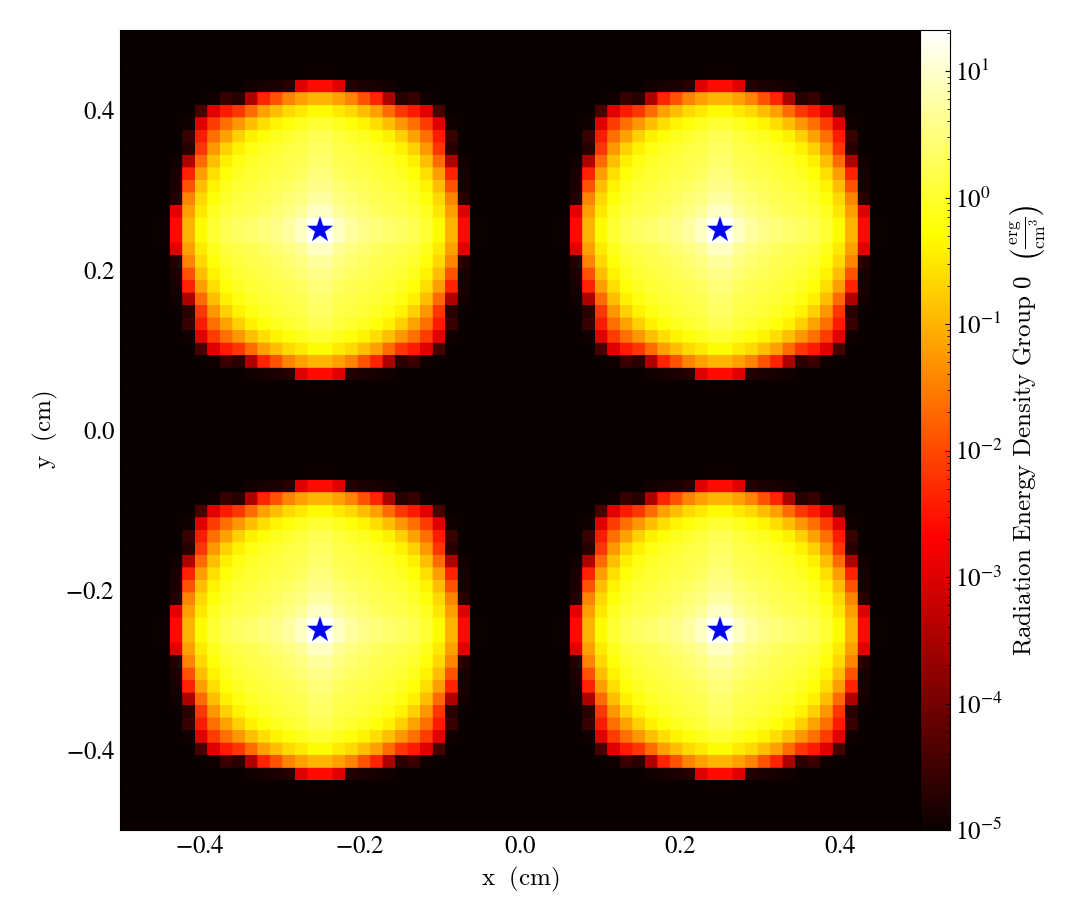

In [8]:
ds2 = yt.load("sample/RadiatingParticles/plt026")
yt.SlicePlot(ds2, "z", ('rad', 'energy_density_0'), center='c').set_cmap(('rad', 'energy_density_0'), 'hot').annotate_particles(1, p_size=400., col='blue', marker='*', ptype='Rad_particles')

In [9]:
ds2.parameters['particle_info']

{'Rad_particles': {'num_particles': 2,
  'num_fields': 3,
  'fields': ['luminosity', 'birth_time', 'end_time'],
  'units': {'luminosity': 'M^1 L^2 T^-3',
   'birth_time': 'T^1',
   'end_time': 'T^1'}}}

Print particle fields in "struct-of-array" format.

In [10]:
# print particle fields
ad = ds2.all_data()
print(ad[('Rad_particles', 'birth_time')])
print(ad[('Rad_particles', 'end_time')])
print(ad[('Rad_particles', 'luminosity')])
# convert luminosity to erg/s
print(ad[('Rad_particles', 'luminosity')].to('erg/s'))

# particle positions
print(ad[('Rad_particles', 'particle_position_x')])
print(ad[('Rad_particles', 'particle_position_y')])

[0. 0. 0. 0.] code_time
[0.5 0.5 0.5 0.5] code_time
[1. 1. 1. 1.] code_length**2*code_mass/code_time**3
[1. 1. 1. 1.] erg/s
[0.75 0.25 0.75 0.25] code_length
[0.75 0.75 0.25 0.25] code_length


## 5. Support for old `QUOKKA` datasets

The `metadata.yaml` is the key to determine if your dataset is a `QUOKKA` data object. If `metadata.yaml` is missing (e.g., data generated by some early versions of `QUOKKA` code), you may bypass metadata parsing to make yt recognize your dataset as a `QUOKKA` dataset:

In [11]:
# from yt.frontends.amrex.data_structures import QuokkaDataset

# class OldQuokkaDataset(QuokkaDataset):
#     def _parse_metadata_file(self):
#         pass

# ds_old = OldQuokkaDataset("sample/RadBeam/plt007")